In [1]:
import os
import datetime

import numpy as np

# from numba import cuda
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from src.model import unet_model
from src.dataset import SegmentationDataset
from src.data_pipeline import SegmentationDataPipeline
from src.data_utils import plot_sample_batch, create_mask, plot_samples_by_class
from src.model_utils import (
    dice_coef,
    dice_loss,
    tversky,
    tversky_loss,
    tversky_axis,
    TverskyLossAxis,
    dice_coef_per_class,
    tversky_per_class,
    evaluate_per_class,
)


%load_ext lab_black
%load_ext autoreload
%autoreload 2

2022-11-21 15:59:38.811826: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-21 15:59:43.938377: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/cuda/lib::/usr/lib/hadoop/lib/native
2022-11-21 15:59:43.940232: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/cuda/lib::/usr/lib/hadoop/lib/native
2022-11-21 1

## Load Test Set

In [2]:
IMG_SHAPE = (256, 1600)
BATCH_SIZE = 8
ANNOTATIONS_PATH = "../data/train.csv"
TRAIN_IMG_PATH = "../data/train_images/"
LOSSES = {
    "dice_loss": dice_loss,
    "tversky_loss": tversky_loss,
    "tversky_loss_axis": TverskyLossAxis(),
}
METRICS = {"dice_coef": dice_coef, "tversky": tversky, "tversky_axis": tversky_axis}
oversample_train_set = False
undersample_train_set = False

# instantiate dataset and pipelne
sd = SegmentationDataset(
    label_file=ANNOTATIONS_PATH,
    img_dir_path=TRAIN_IMG_PATH,
    img_shape=IMG_SHAPE,
    test_size=0.1,
)

# create train/test & x/y splits
train_imgs = sd.train_imgs
test_imgs = sd.test_imgs

if oversample_train_set:
    print("Oversampling train set.")
    train_imgs = sd.resample_train_set(train_imgs, over_sample=True)
elif undersample_train_set:
    print("Undersampling train set.")
    train_imgs = sd.resample_train_set(train_imgs, over_sample=False)

# small sample
_, train_imgs = train_test_split(
    sd.imgid_to_classid_mapping[train_imgs],
    test_size=0.25,
    random_state=42,
    shuffle=True,
    stratify=sd.imgid_to_classid_mapping[train_imgs],
)
_, test_imgs = train_test_split(
    sd.imgid_to_classid_mapping[test_imgs],
    test_size=0.25,
    random_state=42,
    shuffle=True,
    stratify=sd.imgid_to_classid_mapping[test_imgs],
)
train_imgs = list(train_imgs.index)
test_imgs = list(test_imgs.index)

X_train = sd.get_image_sequence(train_imgs)
y_train = sd.get_label_sequence(train_imgs, label_type="preprocessed")
X_test = sd.get_image_sequence(test_imgs)
y_test = sd.get_label_sequence(test_imgs, label_type="preprocessed")

# create dataset pipelines
sdp = SegmentationDataPipeline(
    img_shape=IMG_SHAPE,
    label_type="preprocessed",
    pipeline_options={
        "map_parallel": None,
        "cache": False,
        "shuffle_buffer_size": False,
        "batch_size": BATCH_SIZE,
        "prefetch": False,
    },
)
train_dataset = sdp(X_train, y_train, is_train=True)
test_dataset = sdp(X_test, y_test, is_train=False)

2022-11-21 16:00:12.621805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 16:00:12.788904: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 16:00:12.791871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 16:00:12.798584: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 16:00:12.800947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

AUGMENTING!!
Batching
Batching


## Evaluate Model

In [4]:
# Load model
MODEL_PATH = "/home/cdsw/logs/unet-epochs_201-lr_0.01-channels_512-loss_categorical_crossentropy-small_sample_False/best_model.h5"
unet_model = tf.keras.models.load_model(MODEL_PATH, custom_objects=(LOSSES | METRICS))

#### Overall Metrics

In [5]:
metrics = unet_model.evaluate(test_dataset)

2022-11-21 16:00:59.407072: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8202
2022-11-21 16:01:02.651310: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-21 16:01:02.653540: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-21 16:01:02.653603: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-21 16:01:02.654764: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-21 16:01:02.654878: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


18/18 [==============================] - 17s 200ms/step - loss: 0.0985 - dice_coef: 0.6553 - tversky: 0.6482 - tversky_axis: 0.6715


In [6]:
dict(zip(unet_model.metrics_names, metrics))

{'loss': 0.09847637265920639,
 'dice_coef': 0.65533447265625,
 'tversky': 0.6481627225875854,
 'tversky_axis': 0.6714780926704407}

#### Dice Coef per class

In [7]:
dice_per_class = evaluate_per_class(
    dataset=test_dataset, model=unet_model, metric=dice_coef_per_class
)

  0%|                                                    | 0/18 [00:00<?, ?it/s]

1/1 [==============================] - 0s 448ms/step


  6%|██▍                                         | 1/18 [00:00<00:13,  1.29it/s]

1/1 [==============================] - 0s 62ms/step


 11%|████▉                                       | 2/18 [00:01<00:07,  2.03it/s]

1/1 [==============================] - 0s 60ms/step


 17%|███████▎                                    | 3/18 [00:01<00:06,  2.46it/s]

1/1 [==============================] - 0s 60ms/step


 22%|█████████▊                                  | 4/18 [00:01<00:06,  2.24it/s]

1/1 [==============================] - 0s 64ms/step


 28%|████████████▏                               | 5/18 [00:02<00:05,  2.57it/s]

1/1 [==============================] - 0s 57ms/step


 33%|██████████████▋                             | 6/18 [00:02<00:04,  2.84it/s]

1/1 [==============================] - 0s 64ms/step


 39%|█████████████████                           | 7/18 [00:02<00:03,  2.95it/s]

1/1 [==============================] - 0s 66ms/step


 44%|███████████████████▌                        | 8/18 [00:03<00:03,  3.09it/s]

1/1 [==============================] - 0s 56ms/step


 50%|██████████████████████                      | 9/18 [00:03<00:02,  3.16it/s]

1/1 [==============================] - 0s 59ms/step


 56%|███████████████████████▉                   | 10/18 [00:03<00:02,  3.29it/s]

1/1 [==============================] - 0s 62ms/step


 61%|██████████████████████████▎                | 11/18 [00:03<00:02,  3.36it/s]

1/1 [==============================] - 0s 59ms/step


 67%|████████████████████████████▋              | 12/18 [00:04<00:01,  3.40it/s]

1/1 [==============================] - 0s 62ms/step


 72%|███████████████████████████████            | 13/18 [00:04<00:01,  3.47it/s]

1/1 [==============================] - 0s 62ms/step


 78%|█████████████████████████████████▍         | 14/18 [00:04<00:01,  3.50it/s]

1/1 [==============================] - 0s 69ms/step


 83%|███████████████████████████████████▊       | 15/18 [00:05<00:00,  3.51it/s]

1/1 [==============================] - 0s 59ms/step


 89%|██████████████████████████████████████▏    | 16/18 [00:05<00:00,  3.56it/s]

1/1 [==============================] - 0s 59ms/step


 94%|████████████████████████████████████████▌  | 17/18 [00:05<00:00,  3.63it/s]

1/1 [==============================] - 0s 46ms/step


100%|███████████████████████████████████████████| 18/18 [00:05<00:00,  3.14it/s]


In [9]:
dice_per_class

{1: 0.6552366018295288, 2: 0.45188549160957336}

## Plot Segmentation Predictions by Class

#### Predictions on train set

Batching


2022-11-10 14:23:14.947747: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 419430400 exceeds 10% of free system memory.
2022-11-10 14:23:15.185767: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 419430400 exceeds 10% of free system memory.
2022-11-10 14:23:15.617750: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 419430400 exceeds 10% of free system memory.
2022-11-10 14:23:16.238552: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 419430400 exceeds 10% of free system memory.
2022-11-10 14:23:16.401914: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 104857600 exceeds 10% of free system memory.


1/1 [==============================] - 13s 13s/step


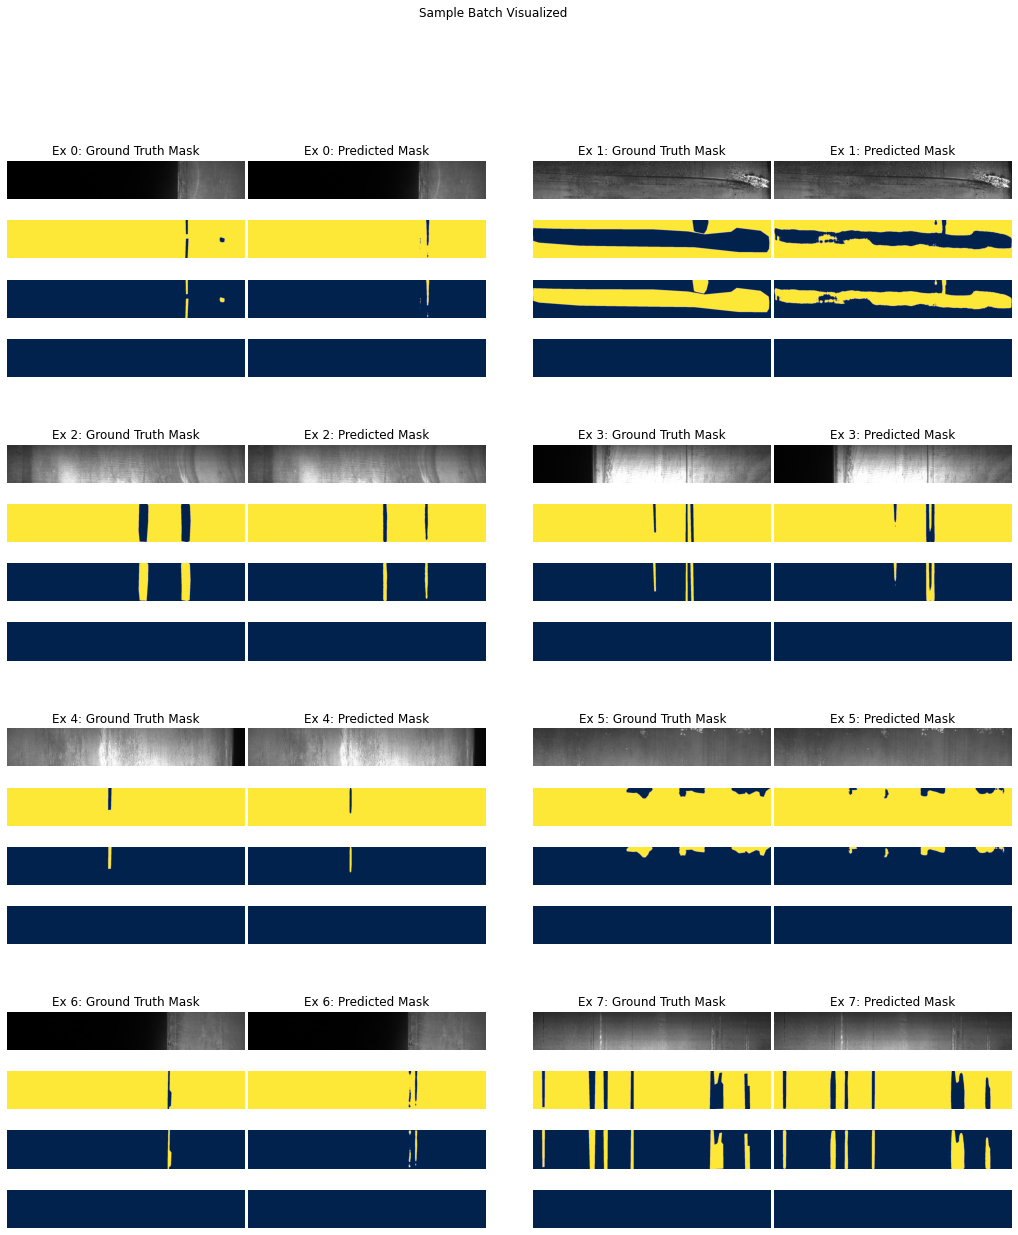

1/1 [==============================] - 11s 11s/step


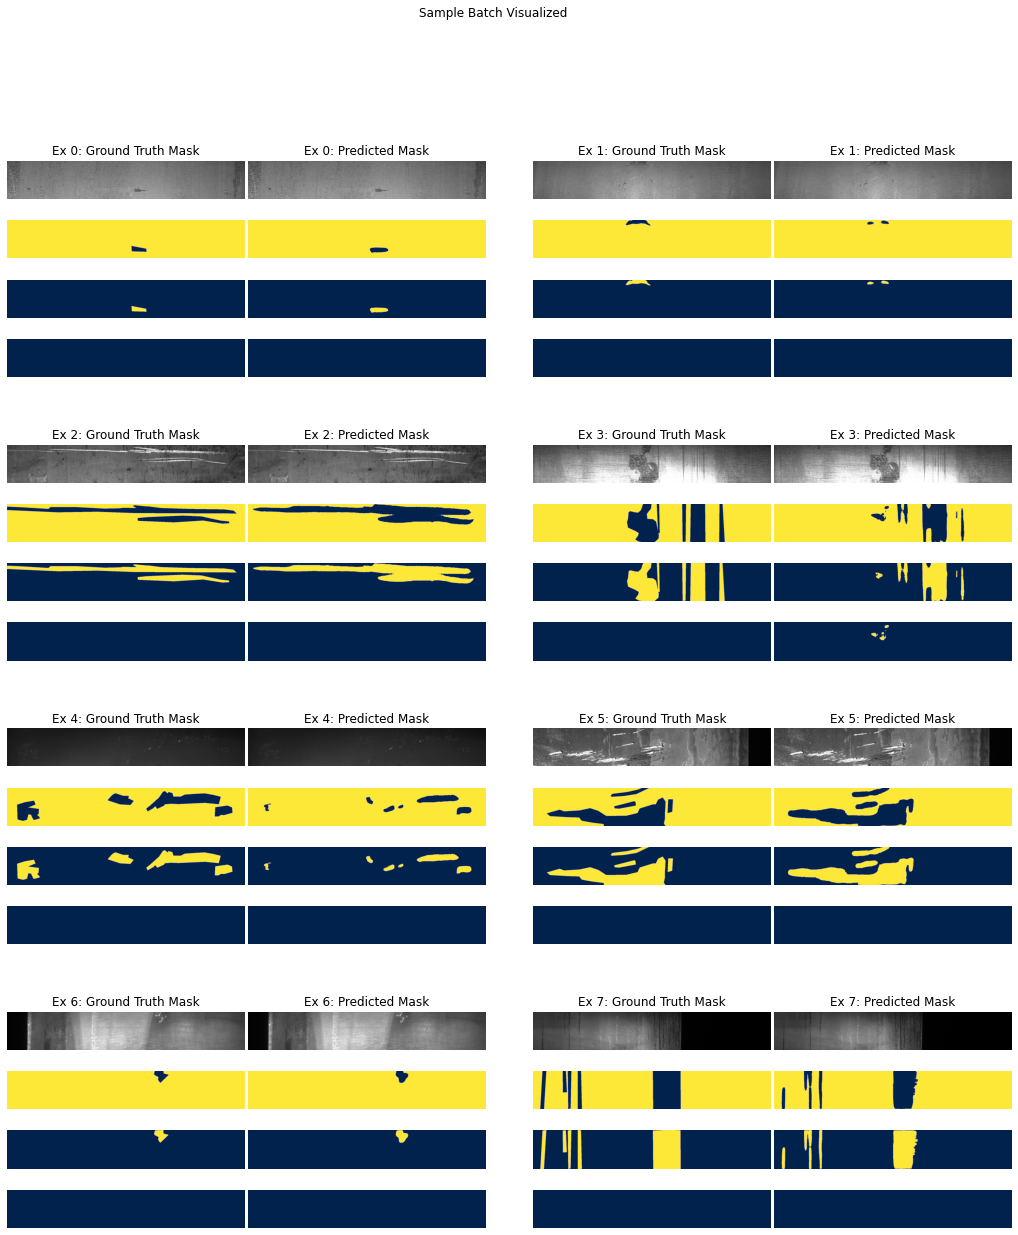

1/1 [==============================] - 11s 11s/step


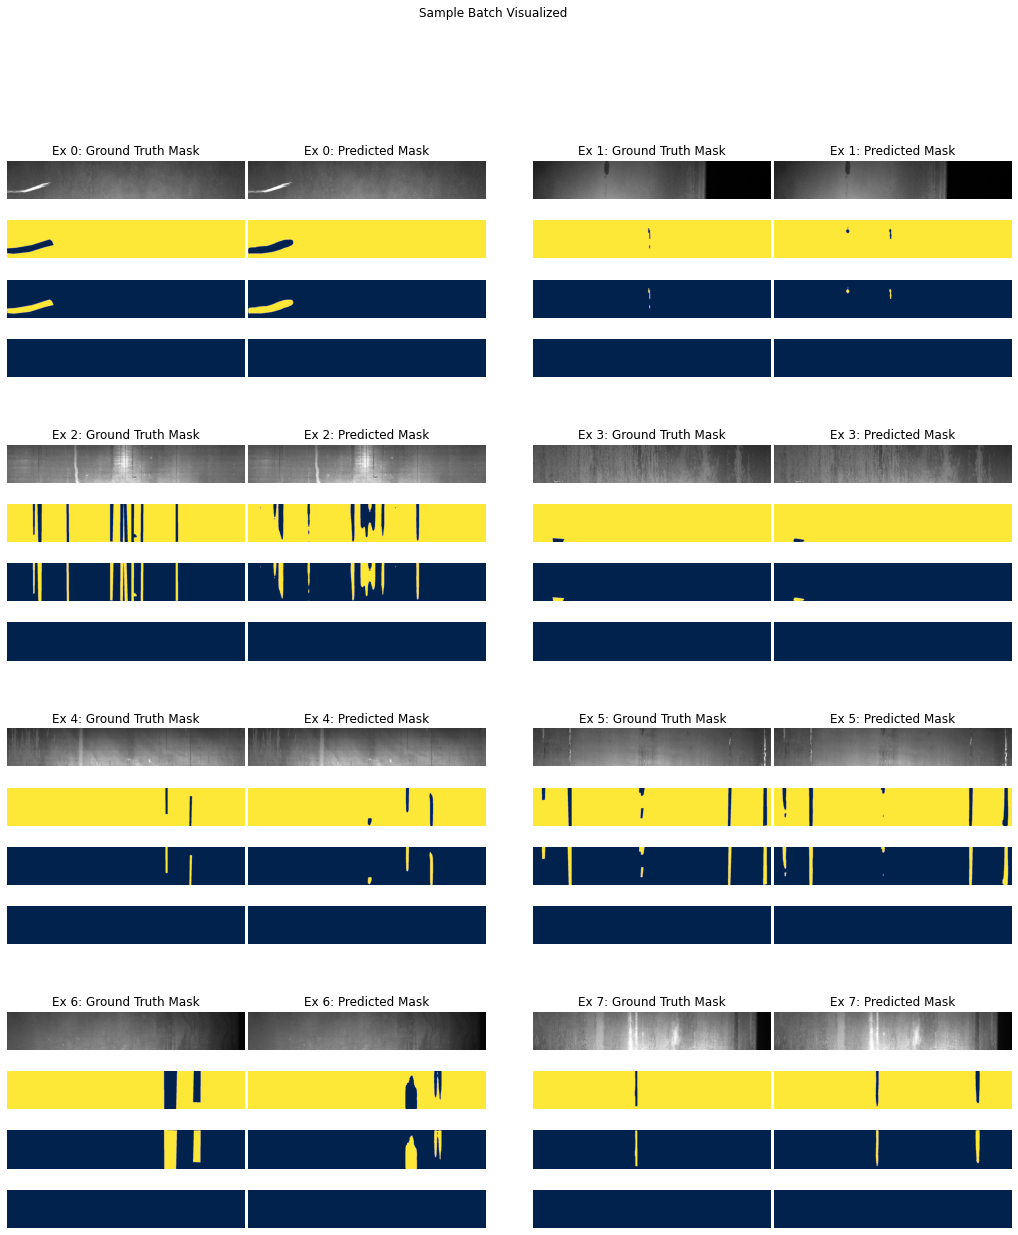

1/1 [==============================] - 11s 11s/step


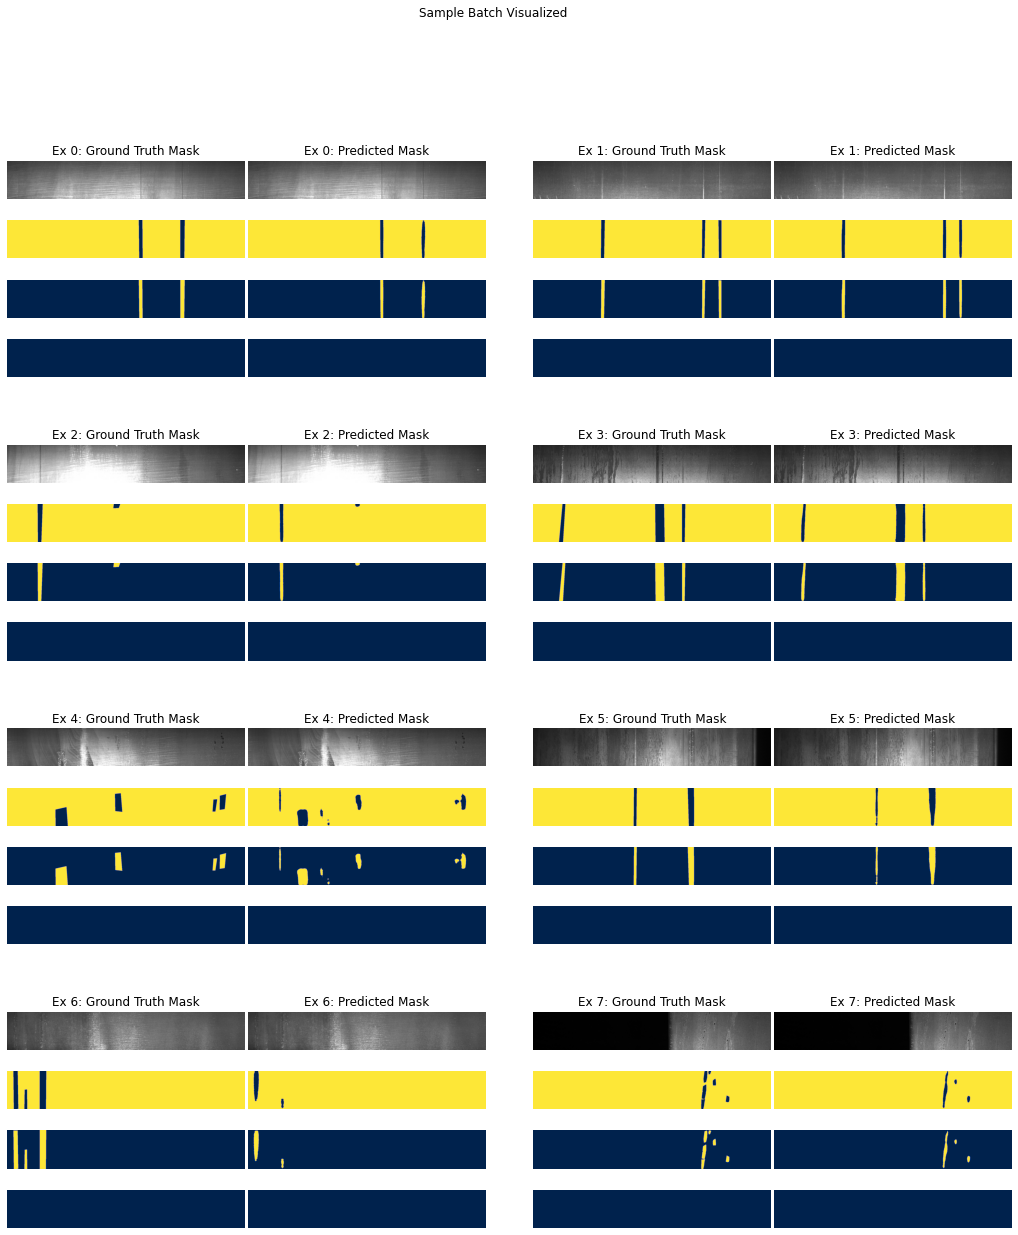

In [5]:
# class 3
plot_samples_by_class(
    class_idx=3, dataset=sd, pipeline=sdp, model=unet_model, n_batches=4, test_set=False
)

Batching
1/1 [==============================] - 11s 11s/step


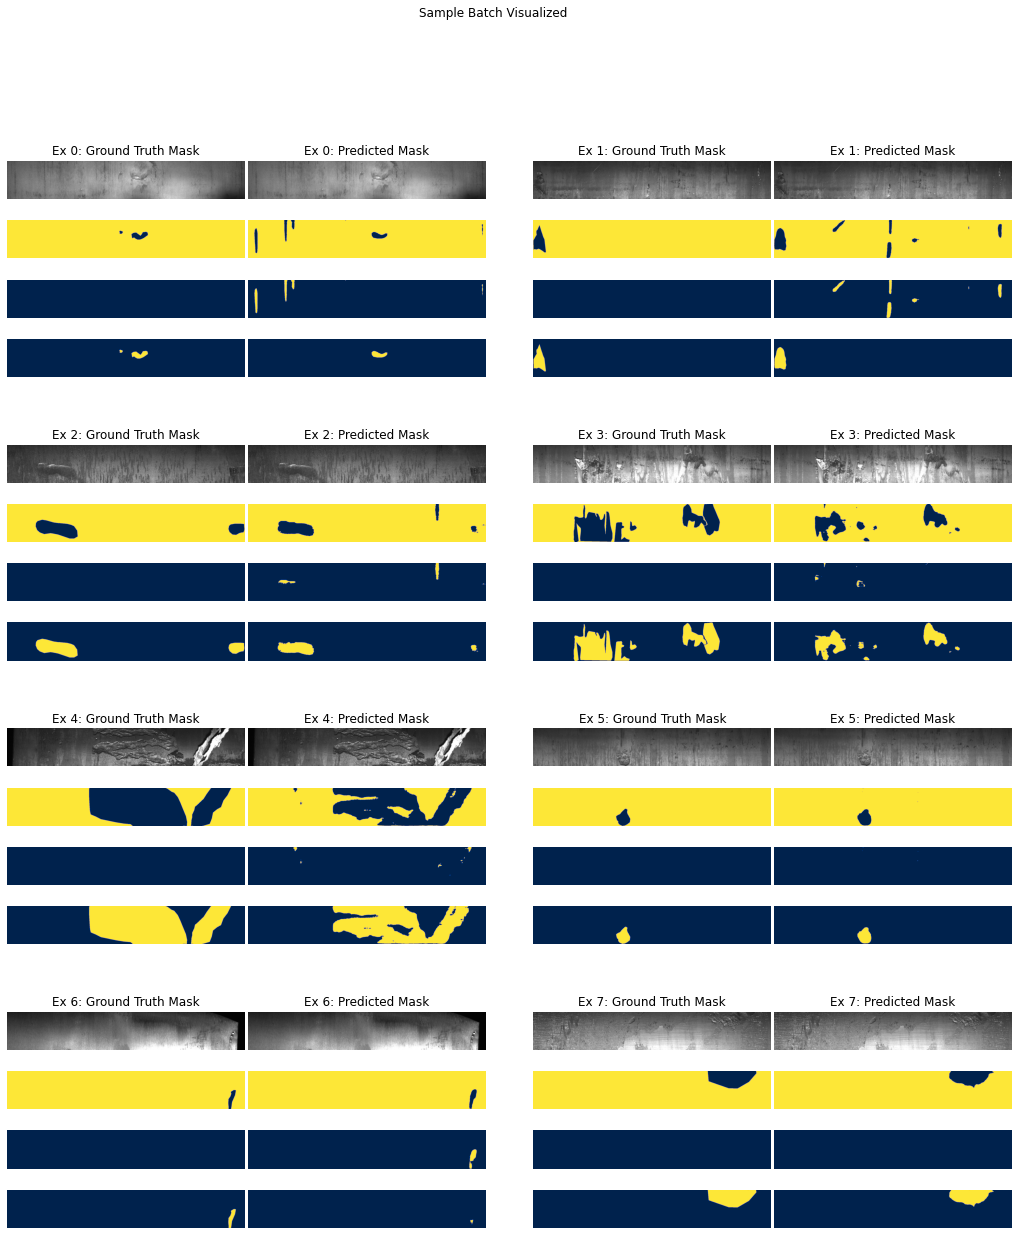

1/1 [==============================] - 11s 11s/step


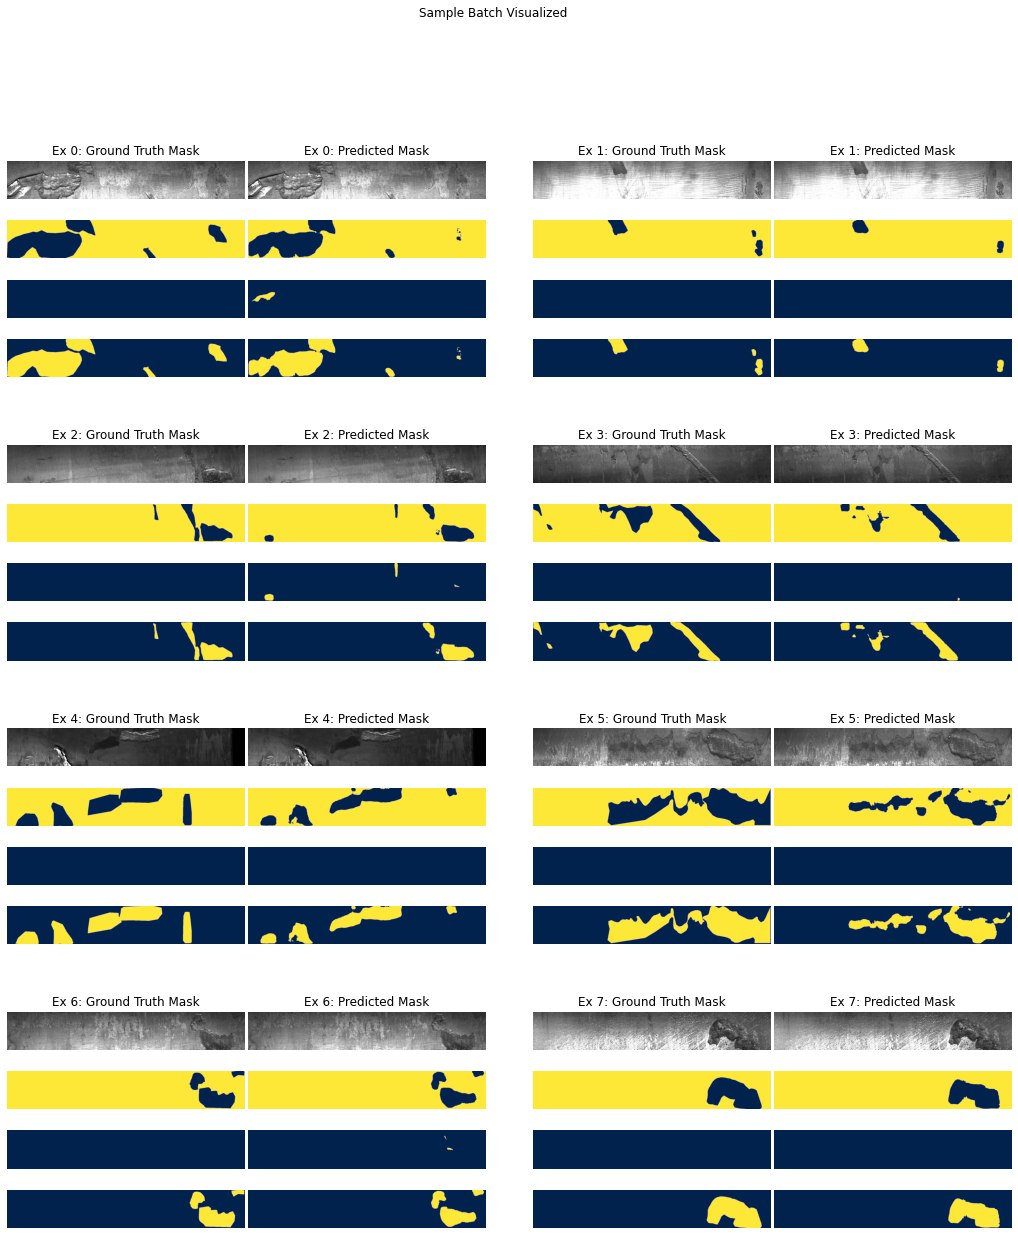

1/1 [==============================] - 11s 11s/step


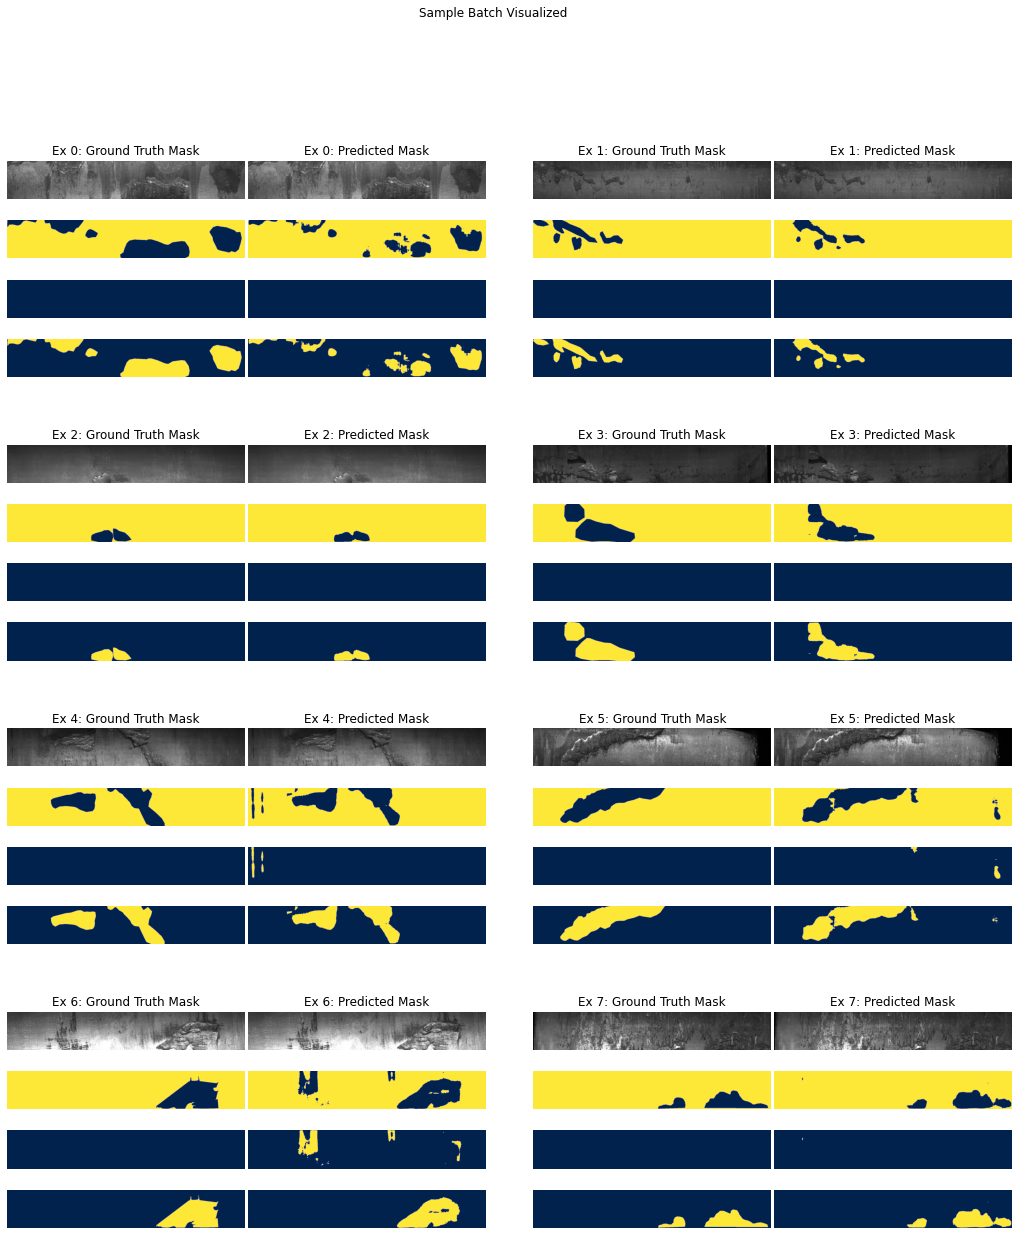

1/1 [==============================] - 11s 11s/step


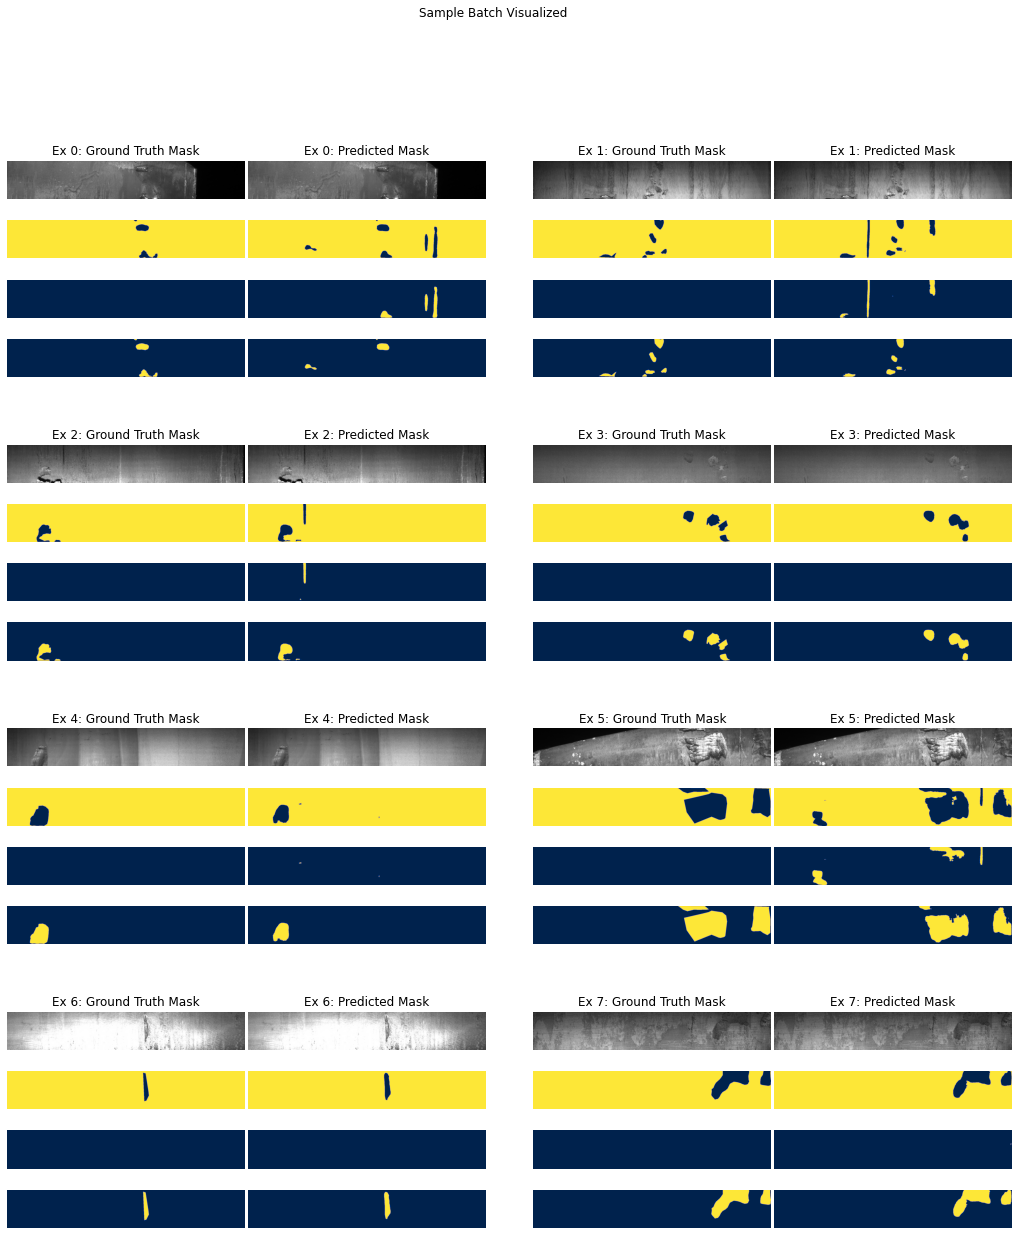

In [6]:
# class 4
plot_samples_by_class(
    class_idx=4, dataset=sd, pipeline=sdp, model=unet_model, n_batches=4, test_set=False
)

#### Predictions on test set

Batching
1/1 [==============================] - 12s 12s/step


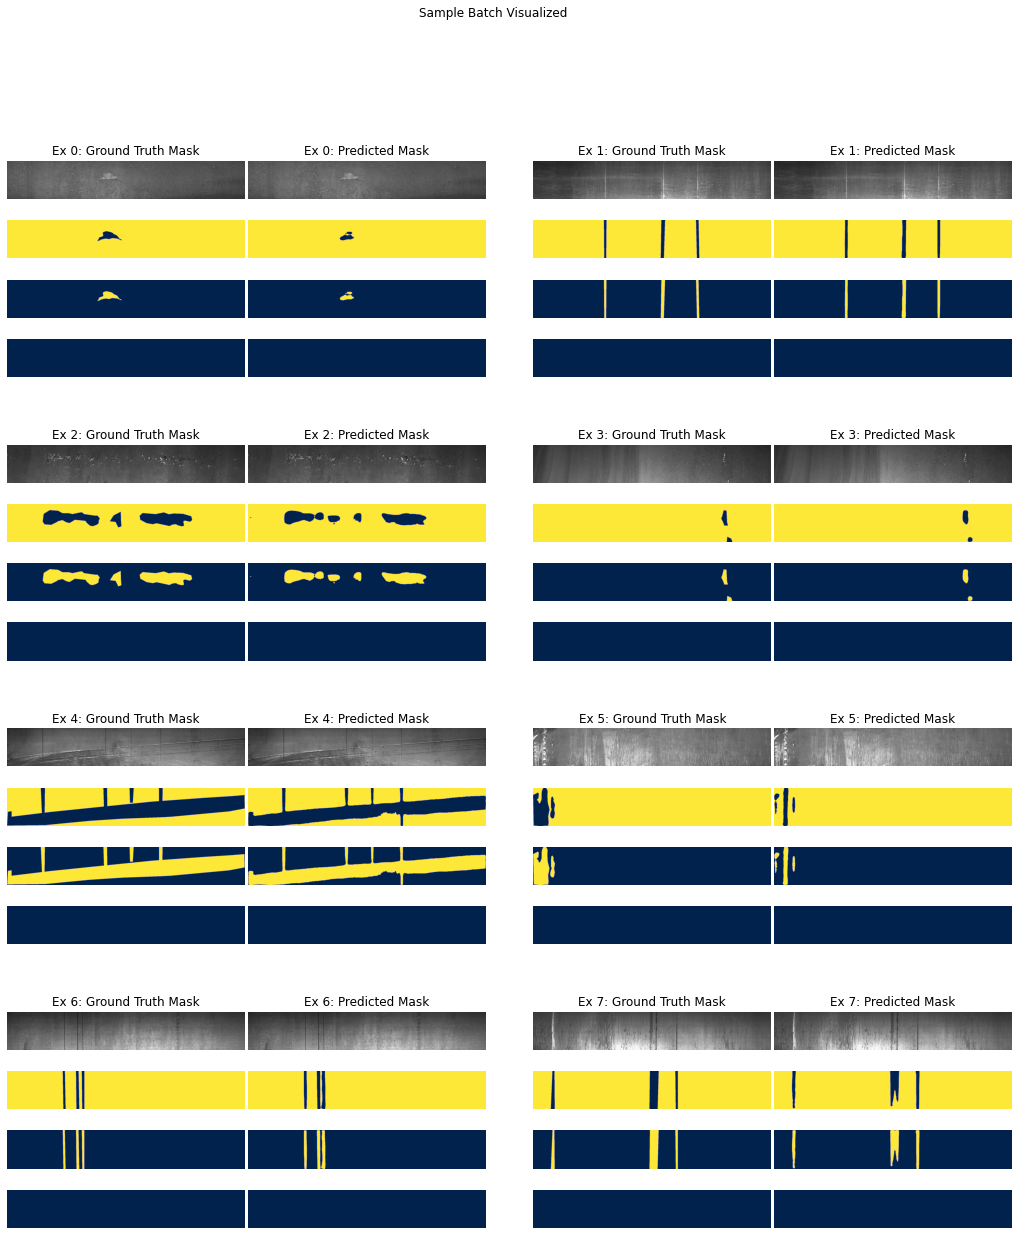

1/1 [==============================] - 10s 10s/step


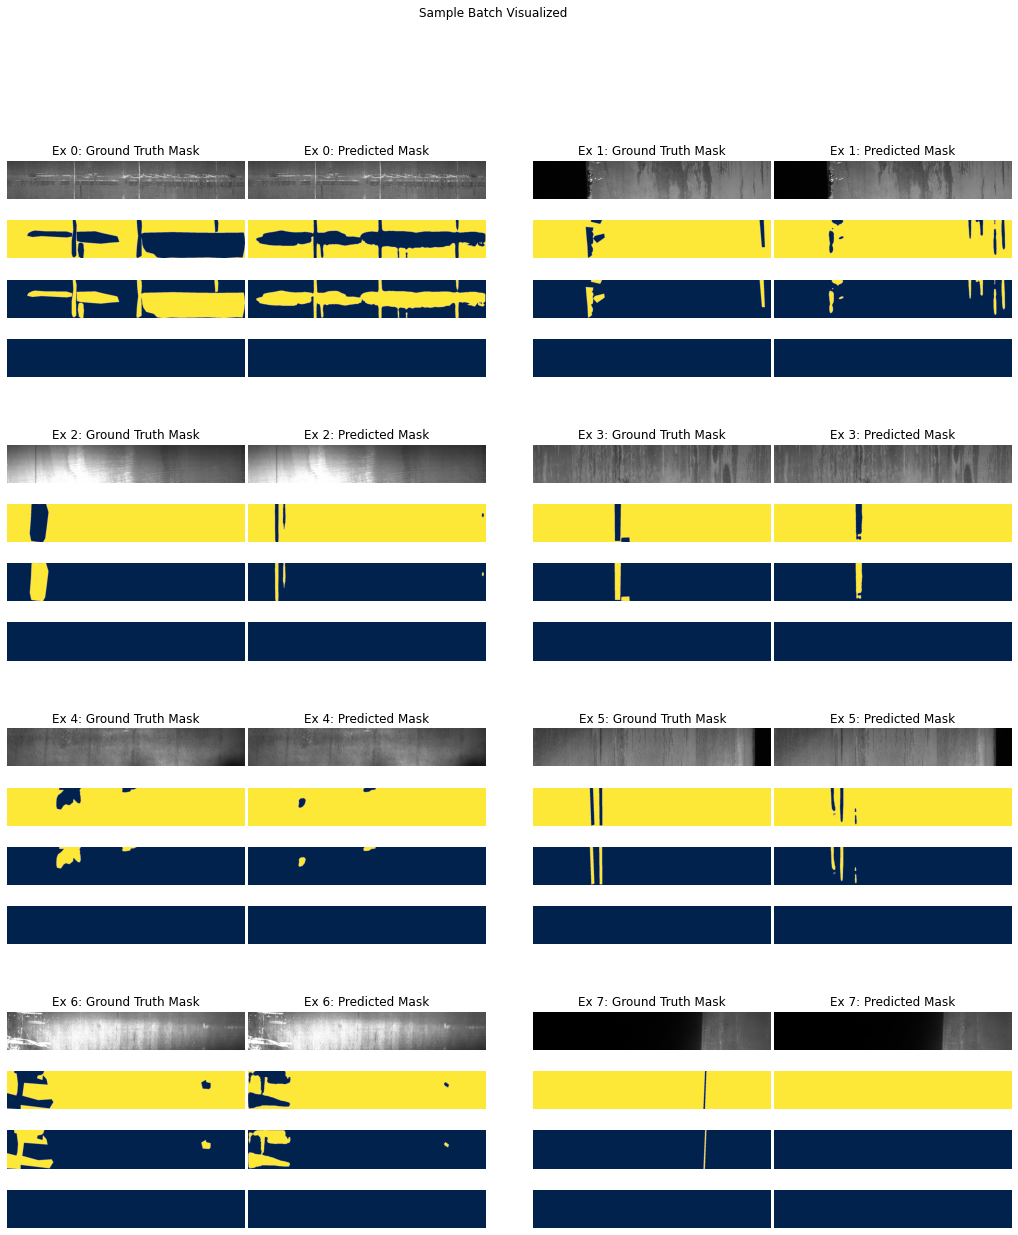

1/1 [==============================] - 10s 10s/step


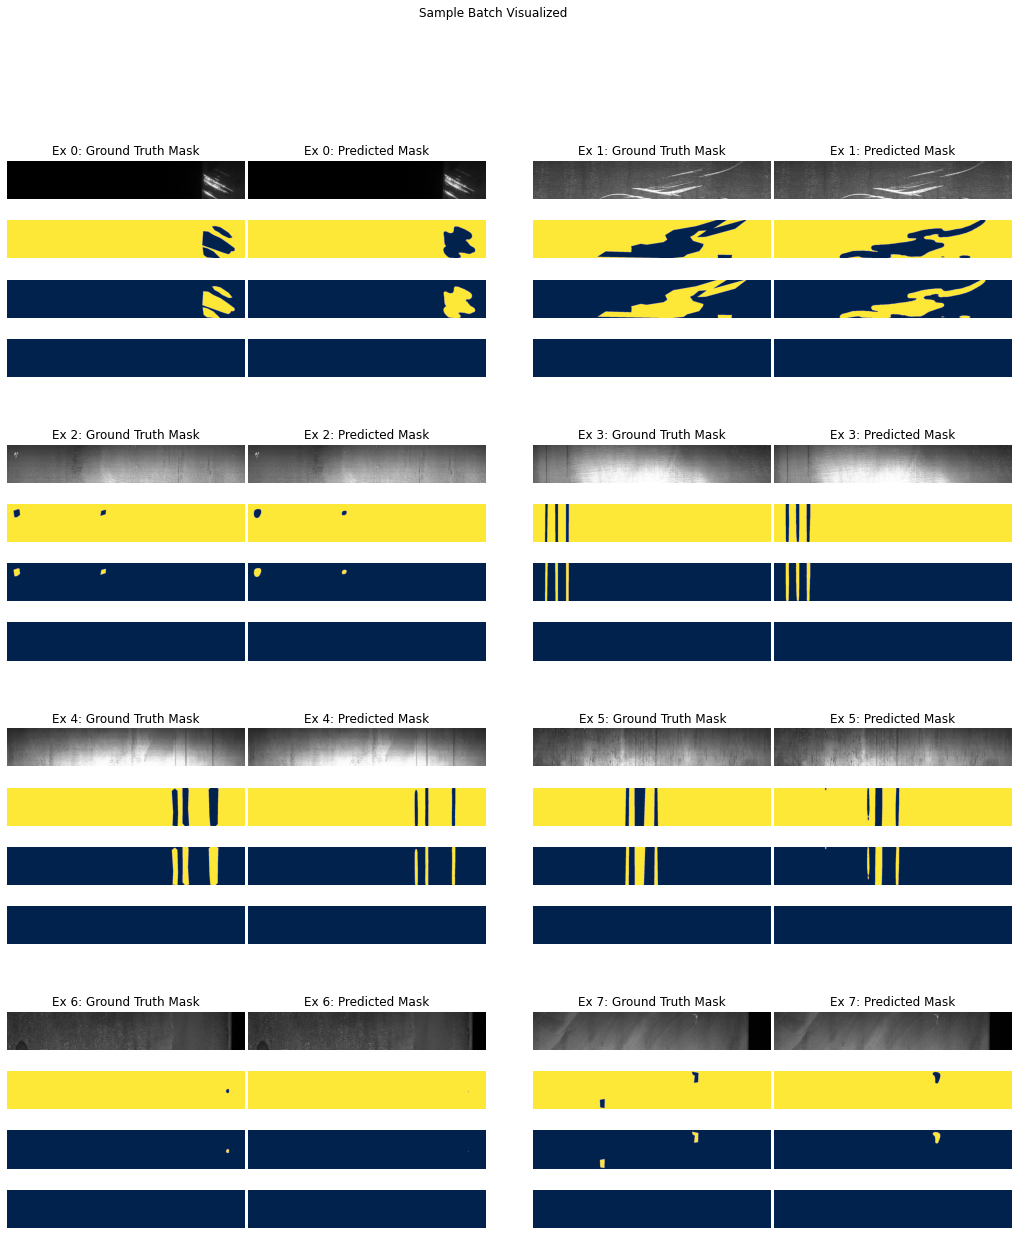

1/1 [==============================] - 10s 10s/step


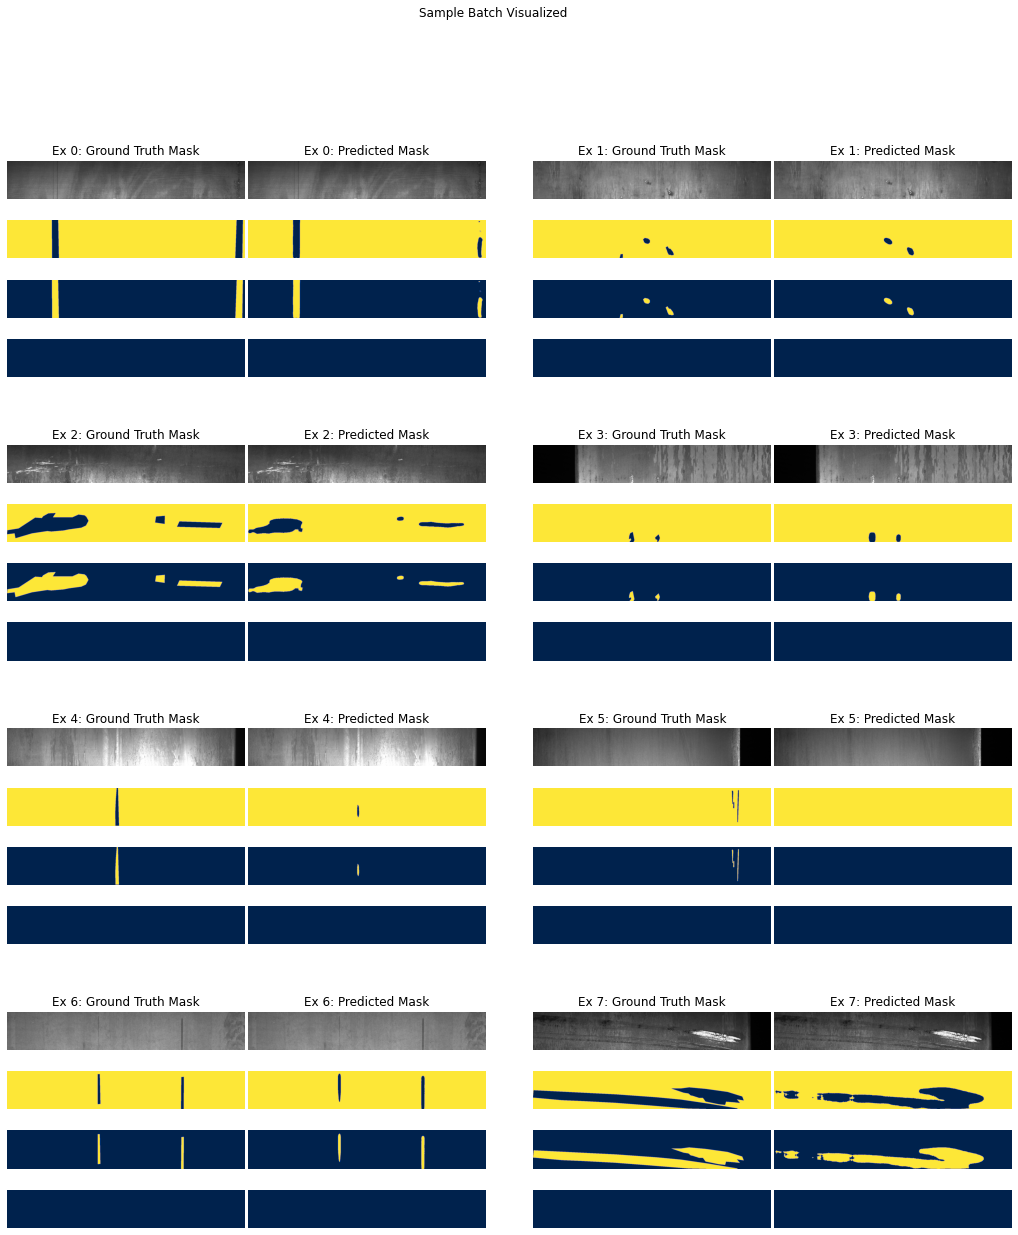

In [16]:
# class 3
plot_samples_by_class(
    class_idx=3, dataset=sd, pipeline=sdp, model=unet_model, n_batches=4, test_set=True
)

Batching
1/1 [==============================] - 10s 10s/step


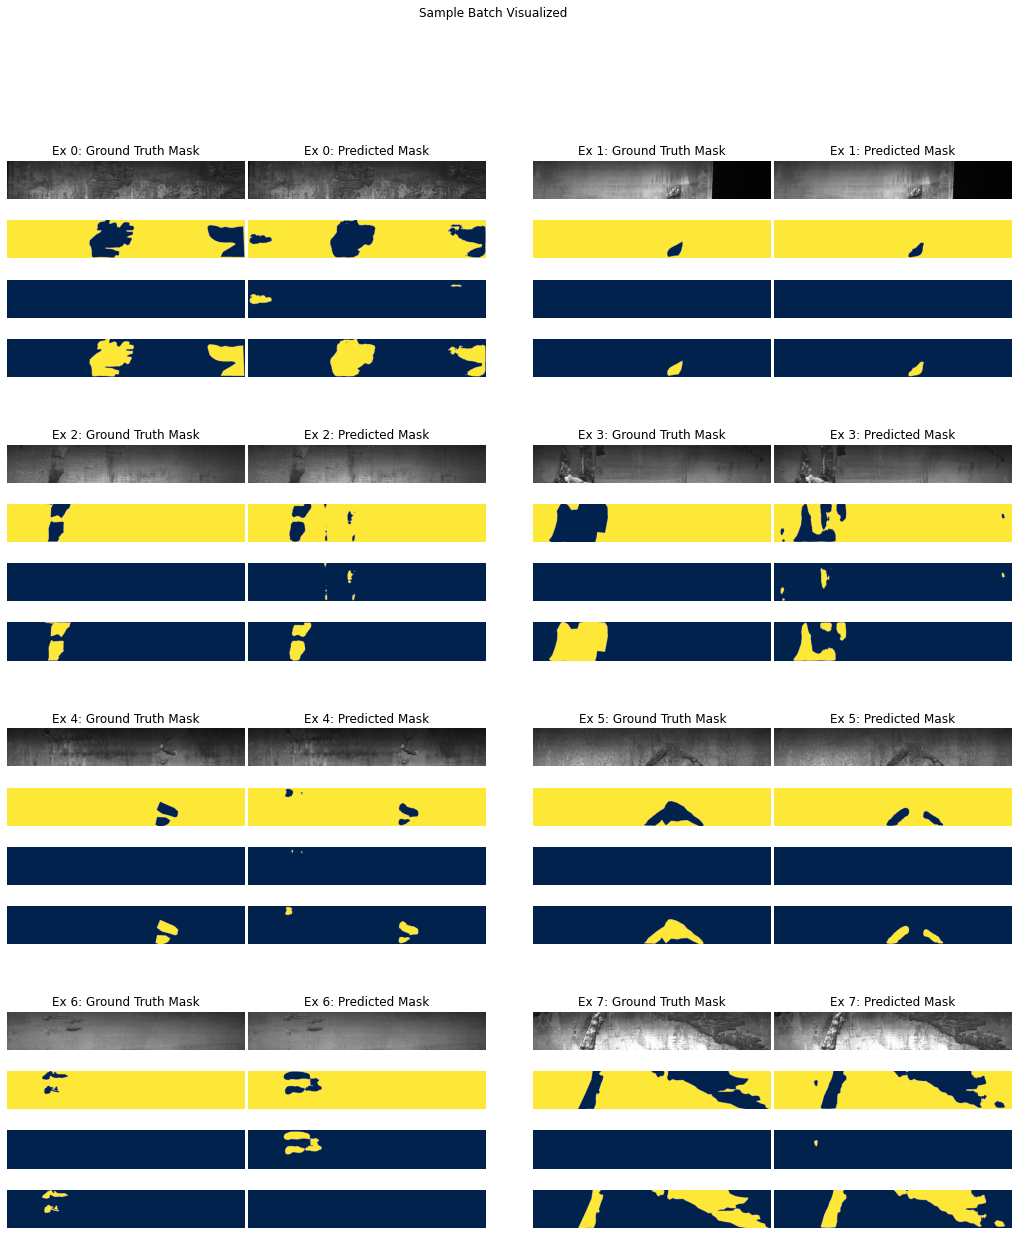

1/1 [==============================] - 10s 10s/step


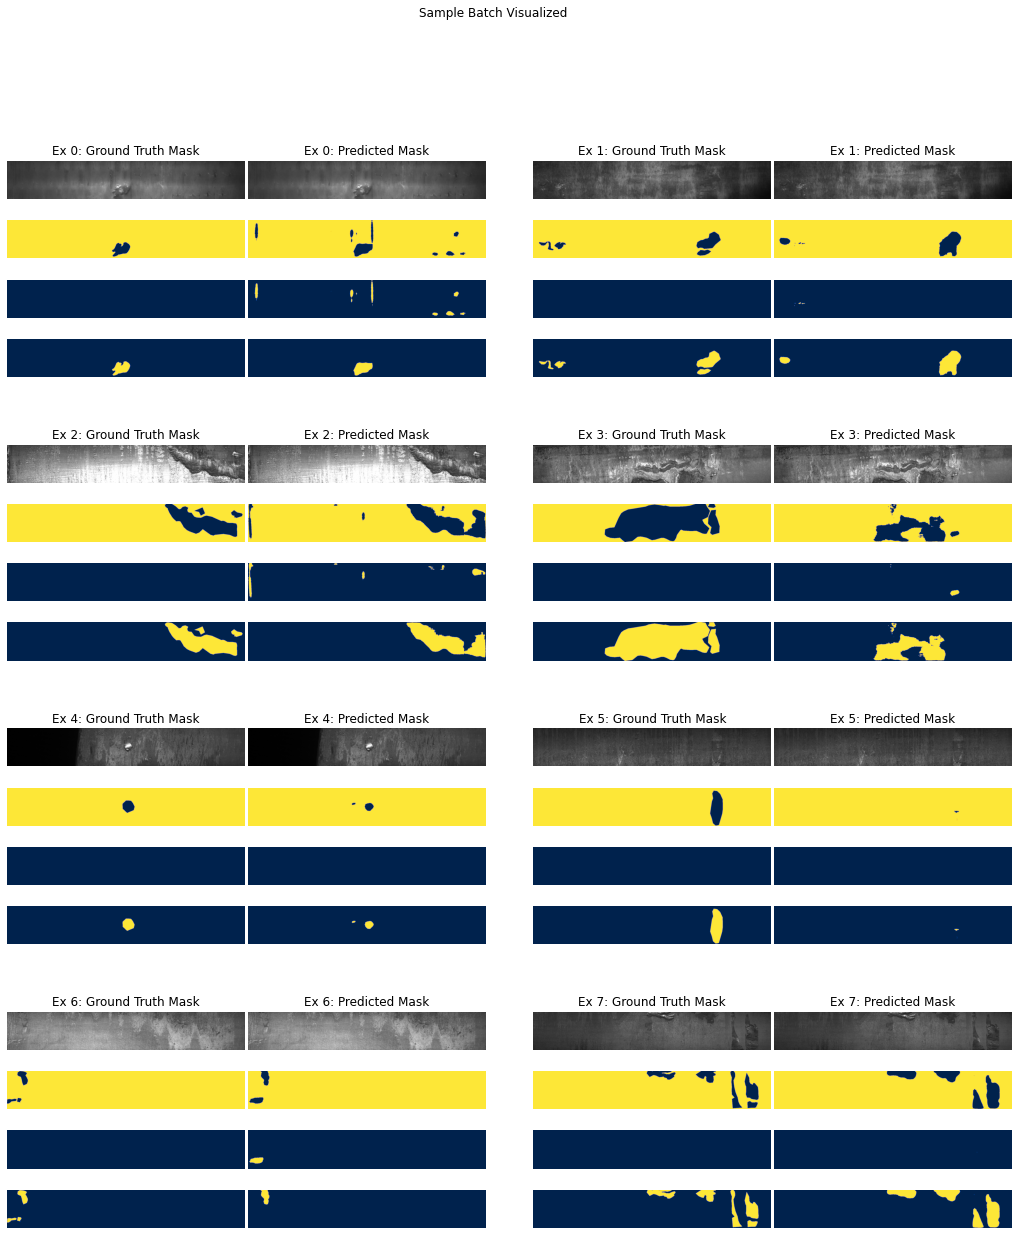

1/1 [==============================] - 11s 11s/step


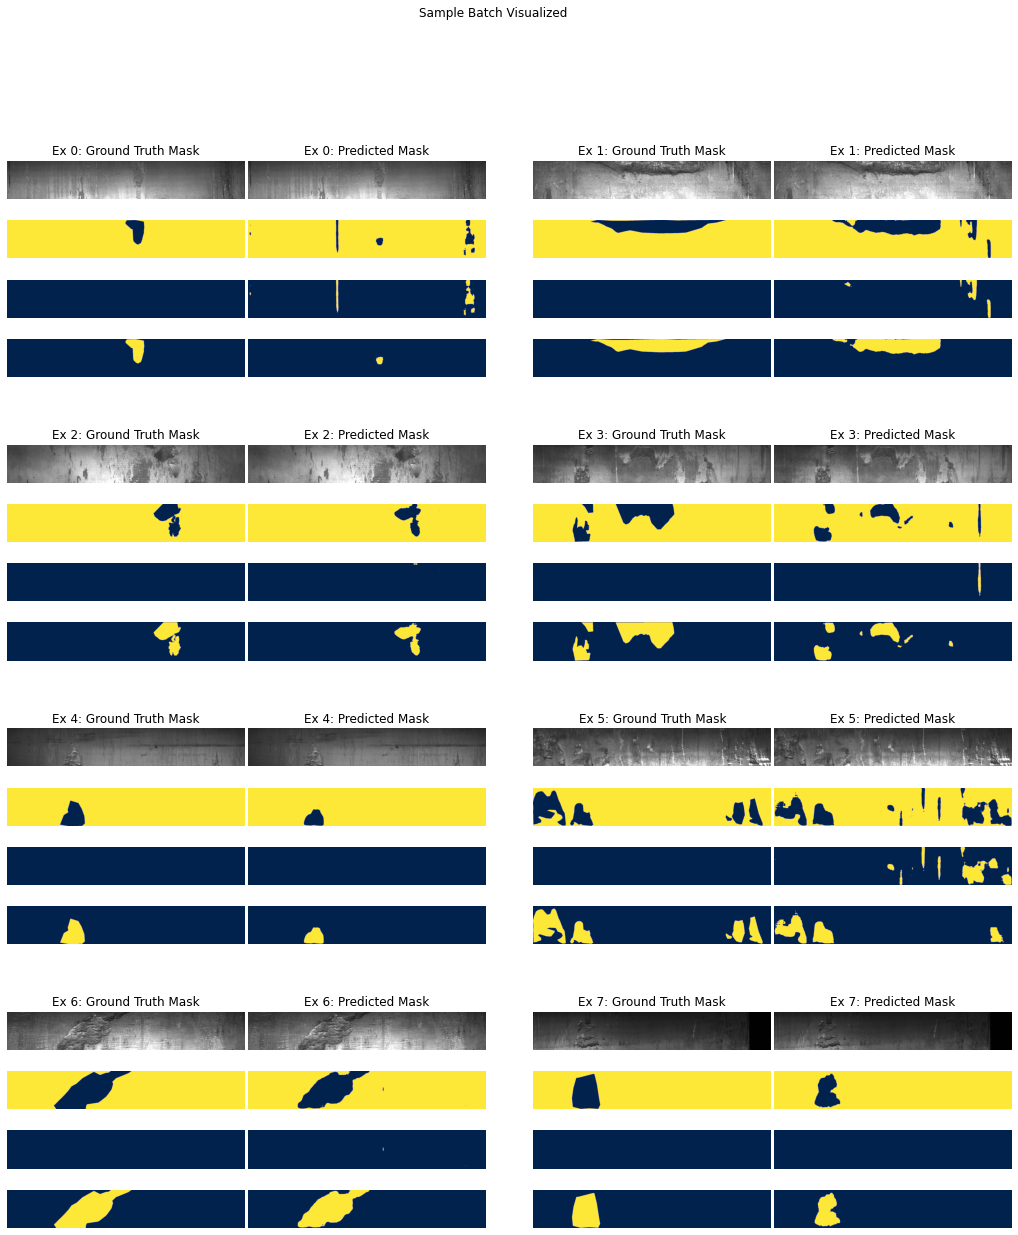

1/1 [==============================] - 10s 10s/step


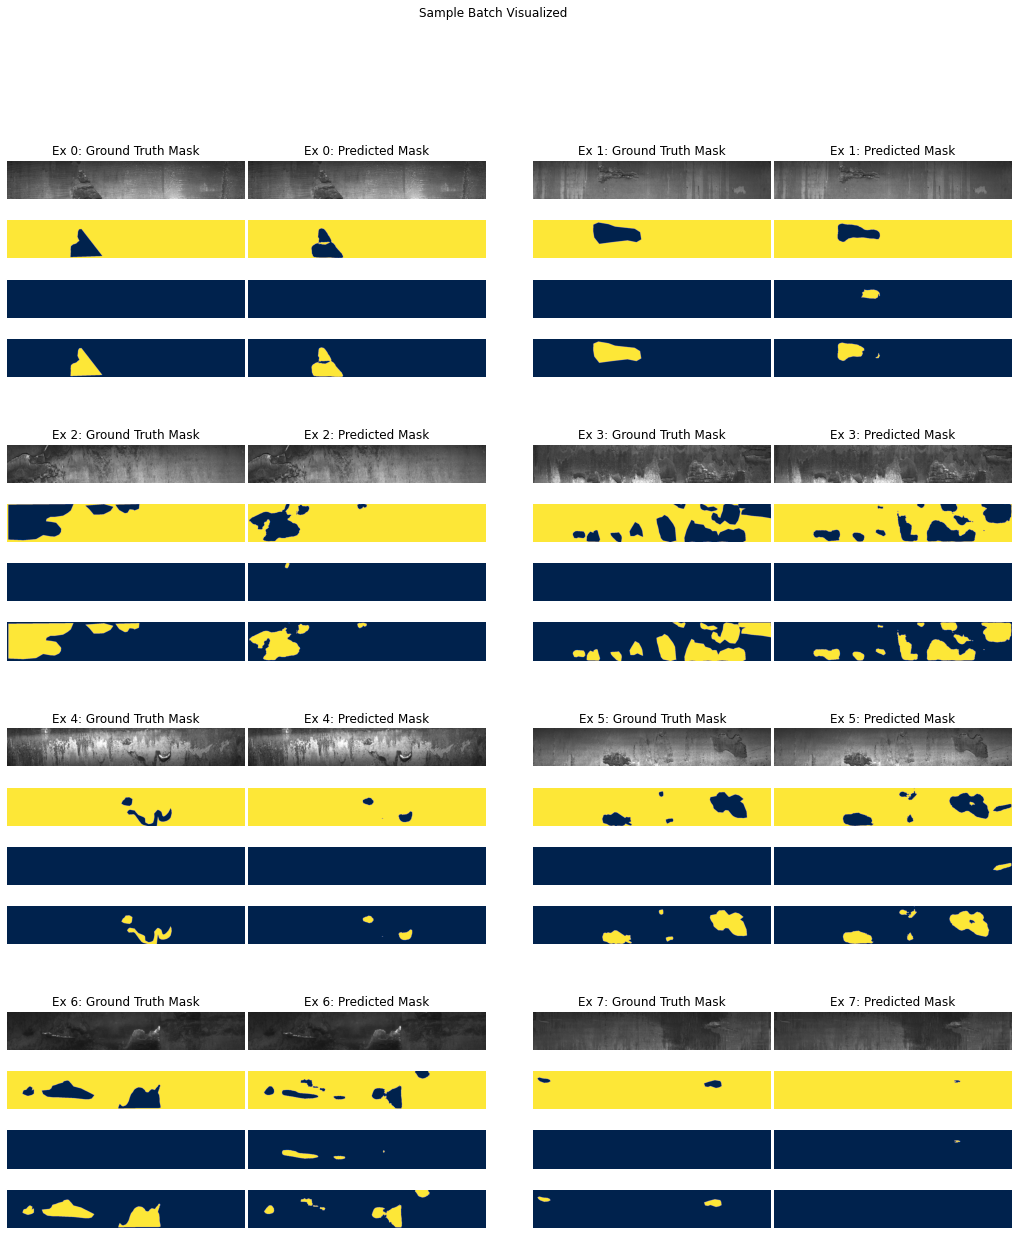

In [17]:
# class 4
plot_samples_by_class(
    class_idx=4, dataset=sd, pipeline=sdp, model=unet_model, n_batches=4, test_set=True
)

Batching


2022-11-10 16:19:14.538761: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 419430400 exceeds 10% of free system memory.
2022-11-10 16:19:14.861915: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 419430400 exceeds 10% of free system memory.
2022-11-10 16:19:15.236907: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 419430400 exceeds 10% of free system memory.
2022-11-10 16:19:15.713798: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 419430400 exceeds 10% of free system memory.
2022-11-10 16:19:21.891272: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 419430400 exceeds 10% of free system memory.


1/1 [==============================] - 13s 13s/step


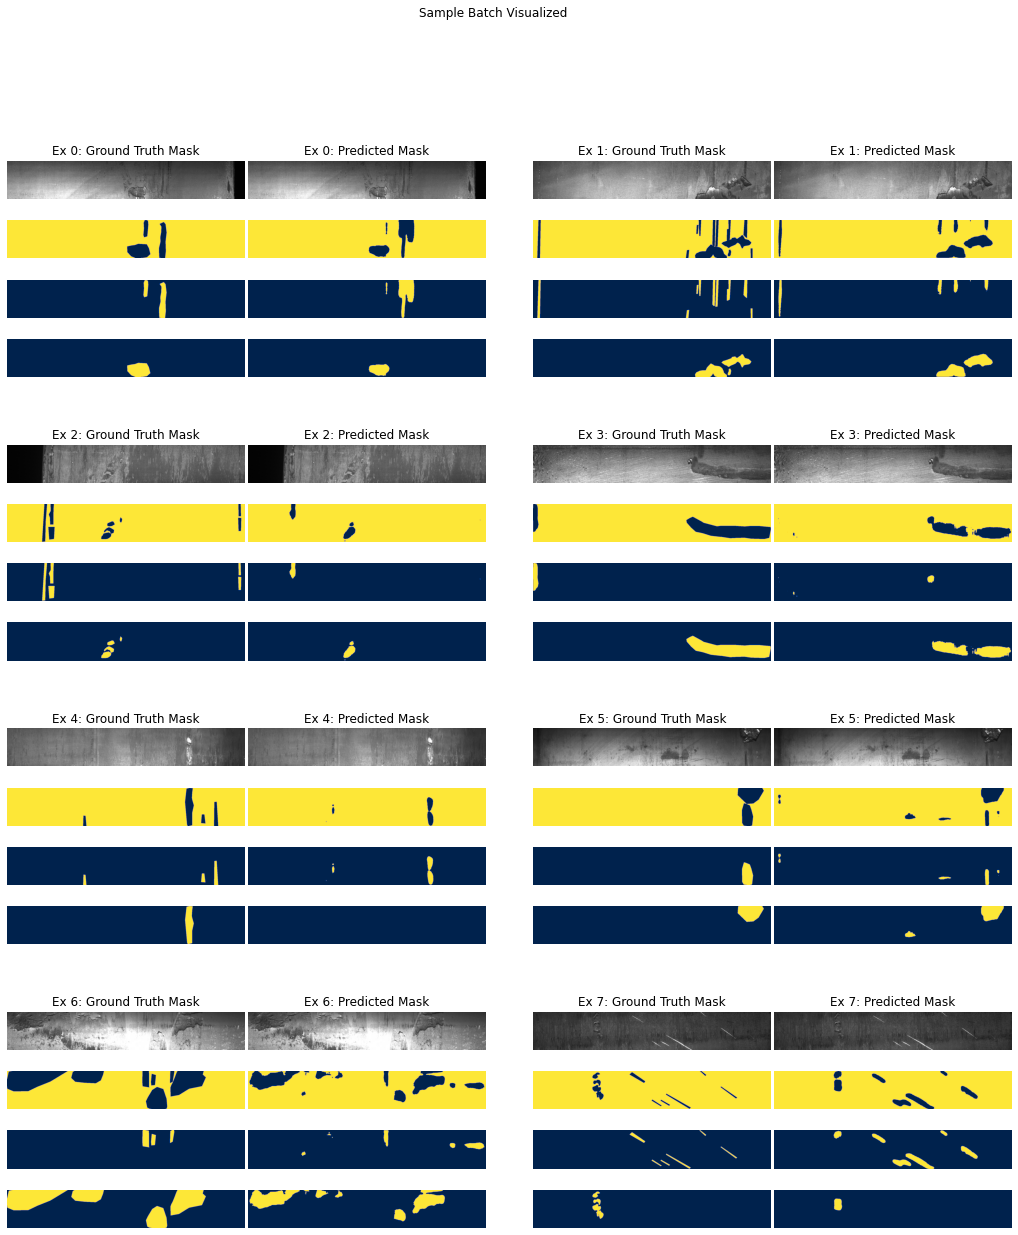

1/1 [==============================] - 11s 11s/step


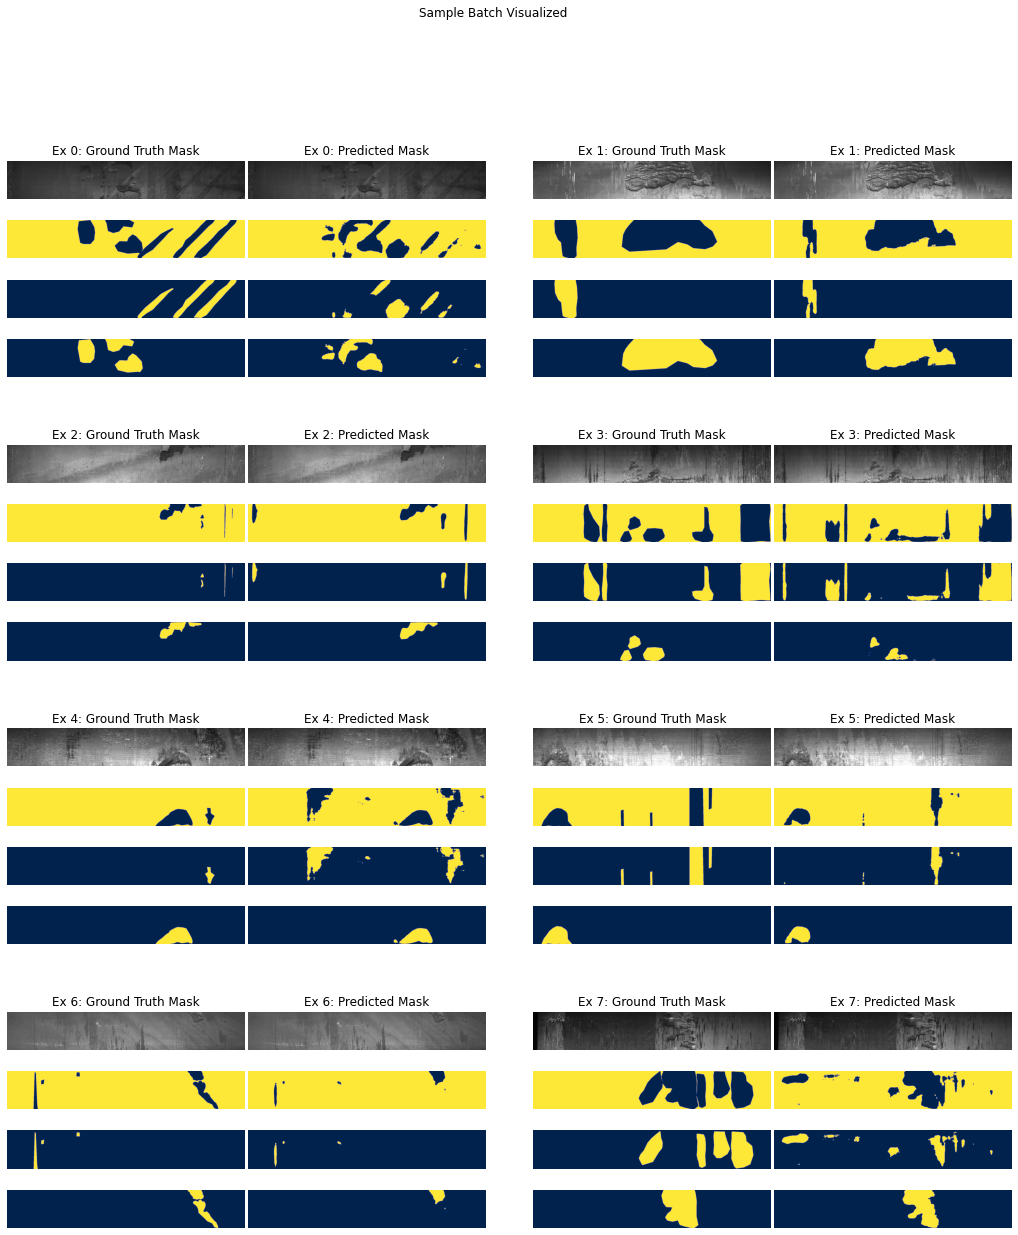

1/1 [==============================] - 10s 10s/step


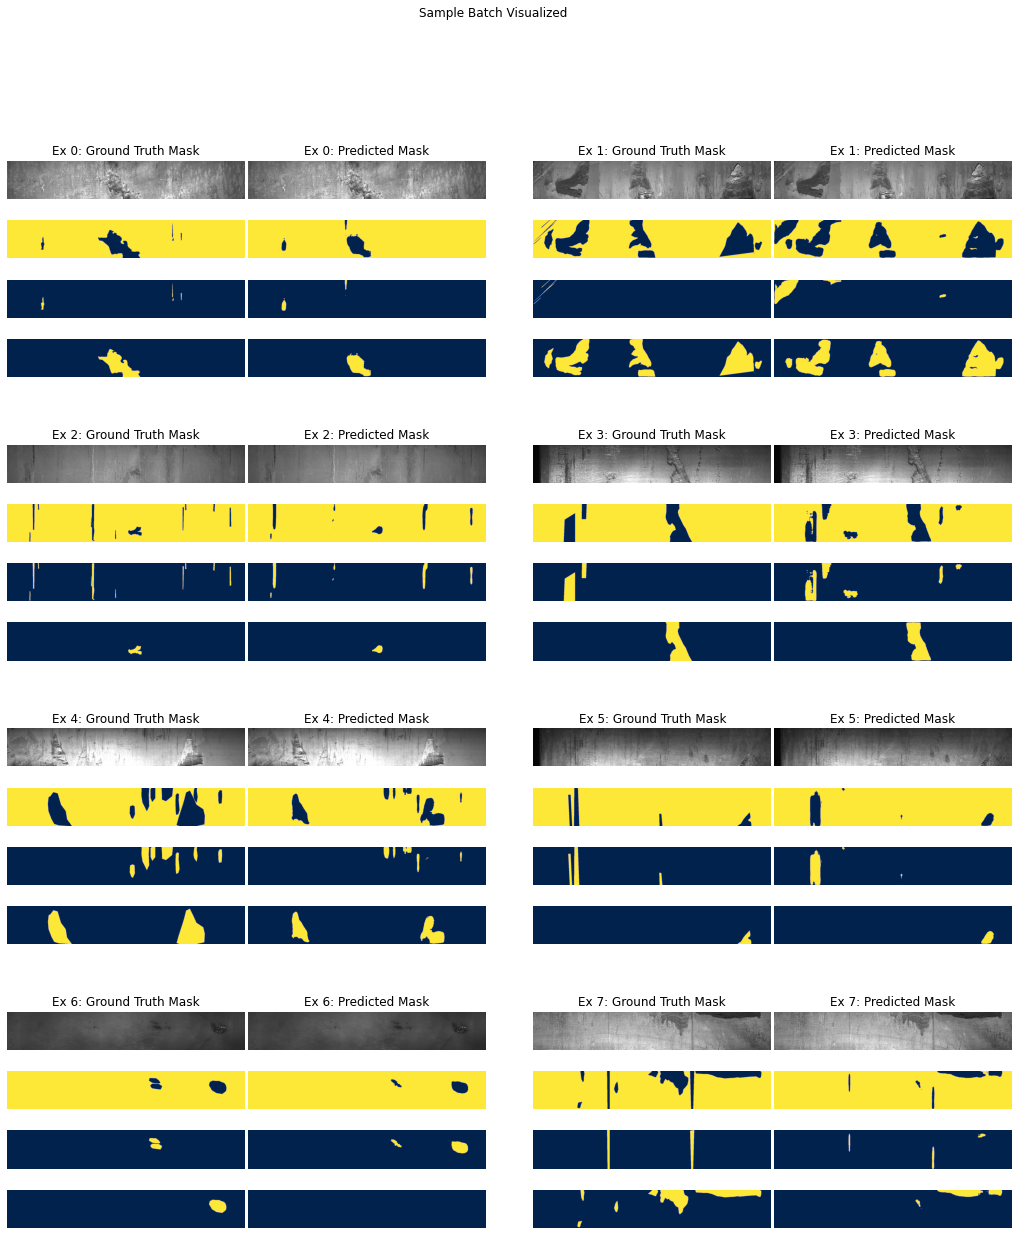

1/1 [==============================] - 5s 5s/step


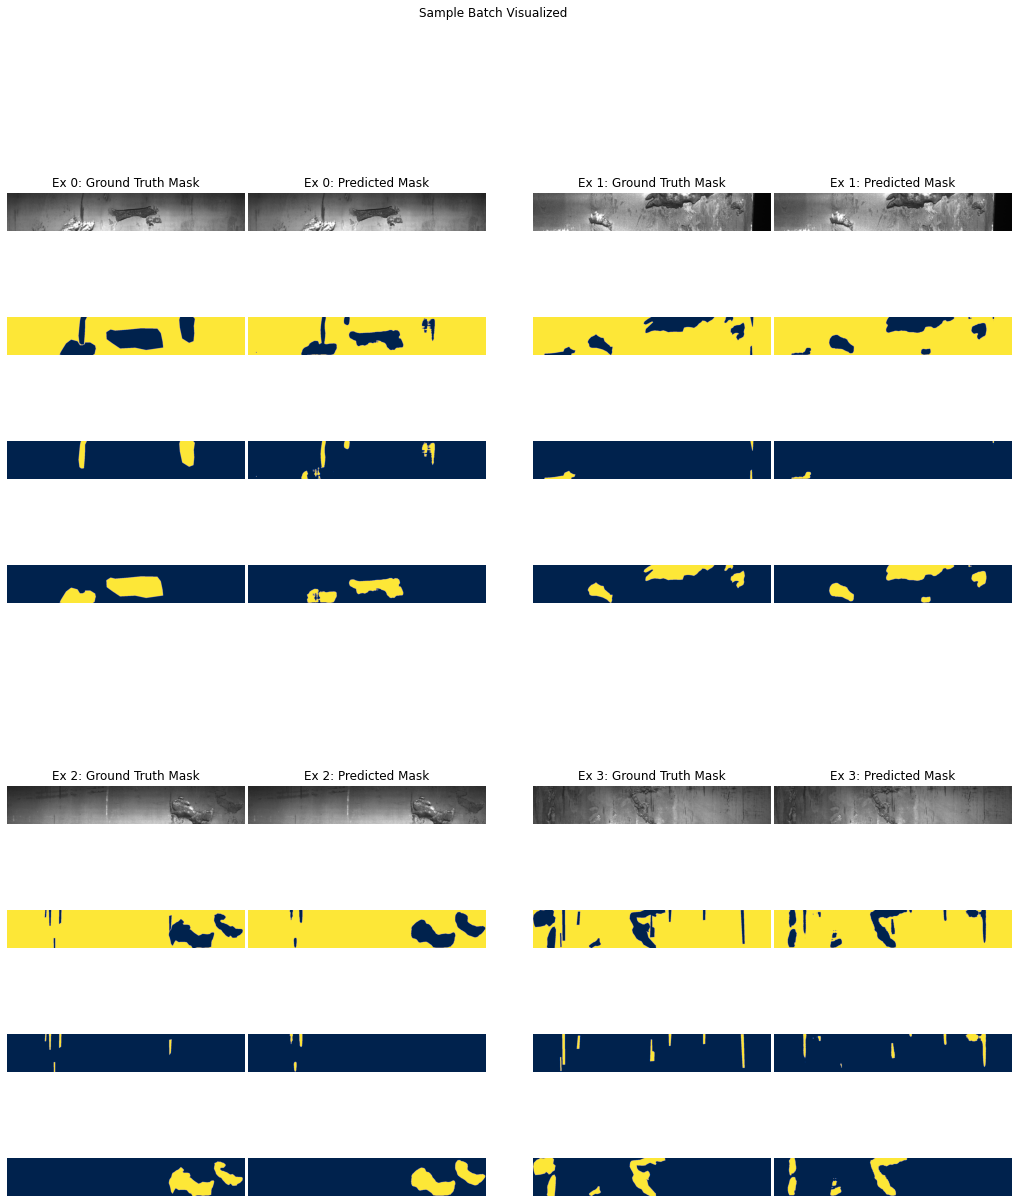

In [7]:
# class -2
plot_samples_by_class(
    class_idx=-2, dataset=sd, pipeline=sdp, model=unet_model, n_batches=4, test_set=True
)

## Inference

In [ ]:
MODEL_PATH = "/home/cdsw/logs/unet-epochs_201-lr_0.01-channels_512-loss_categorical_crossentropy-small_sample_False/best_model.h5"

unet_model = tf.keras.models.load_model(MODEL_PATH, custom_objects=(LOSSES | METRICS))

In [4]:
sample = list(test_dataset.take(1).as_numpy_iterator())

x = sample[0][0]
y_true = sample[0][1]
y_pred = unet_model.predict(x)

x.shape, y_true.shape, y_pred.shape

2022-11-10 18:19:28.294554: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 419430400 exceeds 10% of free system memory.
2022-11-10 18:19:28.508766: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 419430400 exceeds 10% of free system memory.
2022-11-10 18:19:28.849801: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 419430400 exceeds 10% of free system memory.
2022-11-10 18:19:29.333555: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 419430400 exceeds 10% of free system memory.
2022-11-10 18:19:34.977199: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 419430400 exceeds 10% of free system memory.


1/1 [==============================] - 12s 12s/step


((8, 256, 1600, 3), (8, 256, 1600, 3), (8, 256, 1600, 3))

In [8]:
y_pred.shape

(8, 256, 1600, 3)

In [9]:
y_true.shape

(8, 256, 1600, 3)

In [12]:
from src.model_utils import TverskyLossAxis, tversky_loss

In [14]:
tla = TverskyLossAxis()
cce = tf.keras.losses.CategoricalCrossentropy()

In [11]:
tla(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.36105192>

In [13]:
tversky_loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.36105192>

In [15]:
cce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.06309886>

In [7]:
y_pred[0, :, :, :].shape

(256, 1600, 3)

In [9]:
np.sum(y_pred[0, :, :, :], axis=-1).shape

(256, 1600)

In [11]:
np.unique(np.sum(y_pred[0, :, :, :], axis=-1))

array([0.9999997 , 0.99999976, 0.9999998 , 0.9999999 , 0.99999994,
       1.        , 1.0000001 , 1.0000002 ], dtype=float32)

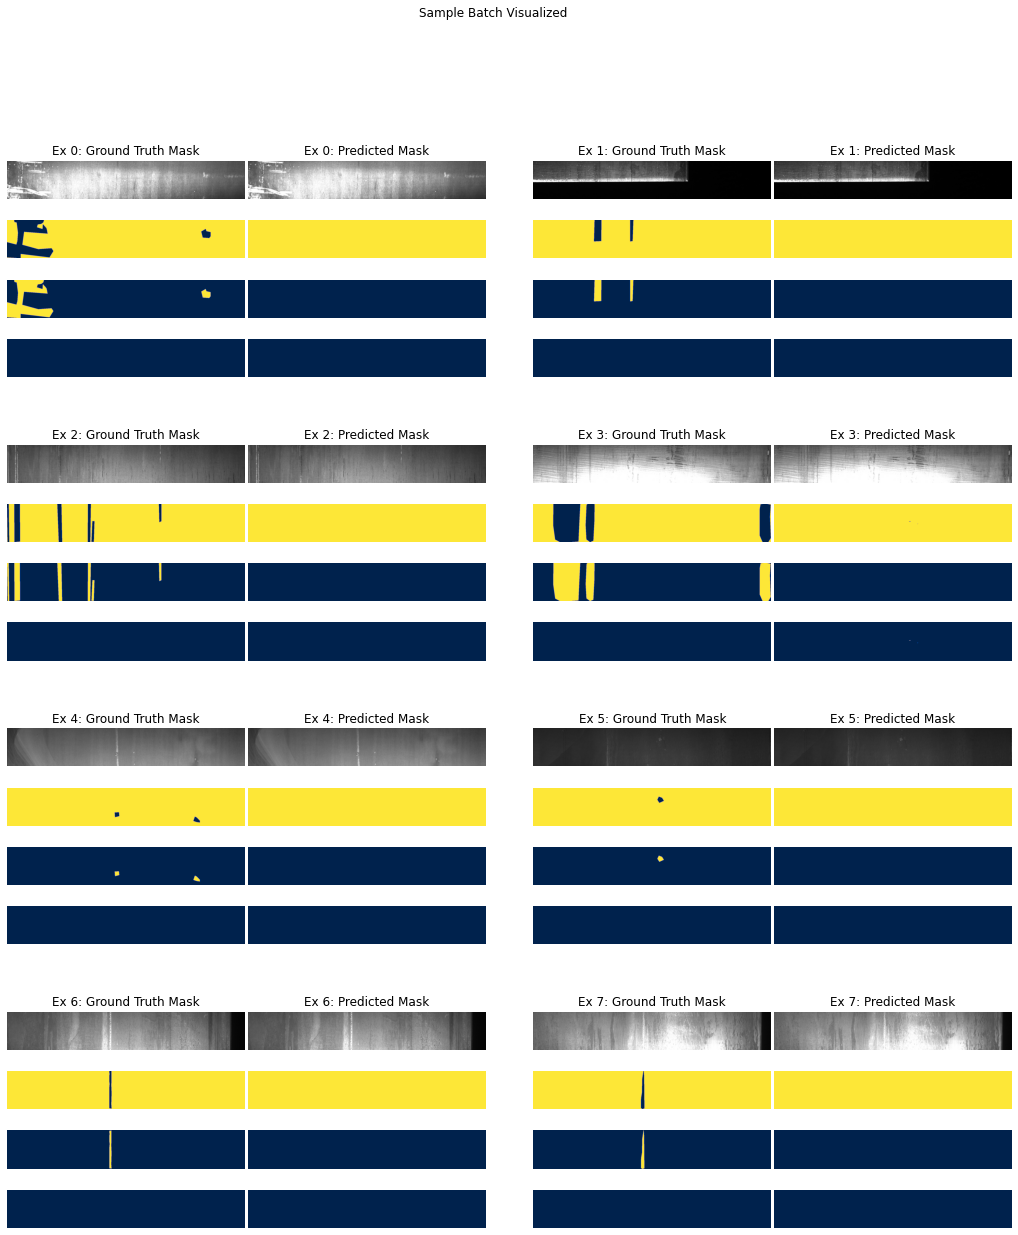

In [29]:
plot_sample_batch(x=x, y_true=y_true, y_pred=y_pred)

In [31]:
cce = tf.keras.losses.CategoricalCrossentropy()

In [32]:
cce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8048158>